In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from joblib import Parallel, delayed, cpu_count
import matplotlib.pyplot as plt


In [2]:
# Load the dataset
data = pd.read_csv('USCensus1990.data.csv')

# Select relevant columns
features = data[['dAge', 'dIncome1']]

# Handle missing values if any (e.g., fill with mean)
features = features.fillna(features.mean())

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

#print(data.head())
print(data.info())
print(features)
#print(len(scaled_features))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709551 entries, 0 to 709550
Data columns (total 69 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   caseid     709551 non-null  int64  
 1   dAge       709551 non-null  int64  
 2   dAncstry1  709551 non-null  int64  
 3   dAncstry2  709551 non-null  int64  
 4   iAvail     709551 non-null  int64  
 5   iCitizen   709551 non-null  int64  
 6   iClass     709551 non-null  int64  
 7   dDepart    709551 non-null  int64  
 8   iDisabl1   709551 non-null  int64  
 9   iDisabl2   709551 non-null  int64  
 10  iEnglish   709551 non-null  int64  
 11  iFeb55     709551 non-null  int64  
 12  iFertil    709551 non-null  int64  
 13  dHispanic  709551 non-null  int64  
 14  dHour89    709551 non-null  int64  
 15  dHours     709551 non-null  int64  
 16  iImmigr    709551 non-null  int64  
 17  dIncome1   709551 non-null  int64  
 18  dIncome2   709551 non-null  int64  
 19  dIncome3   709551 non-n

Elapsed time for elbow method is : 143966.01 milliseconds


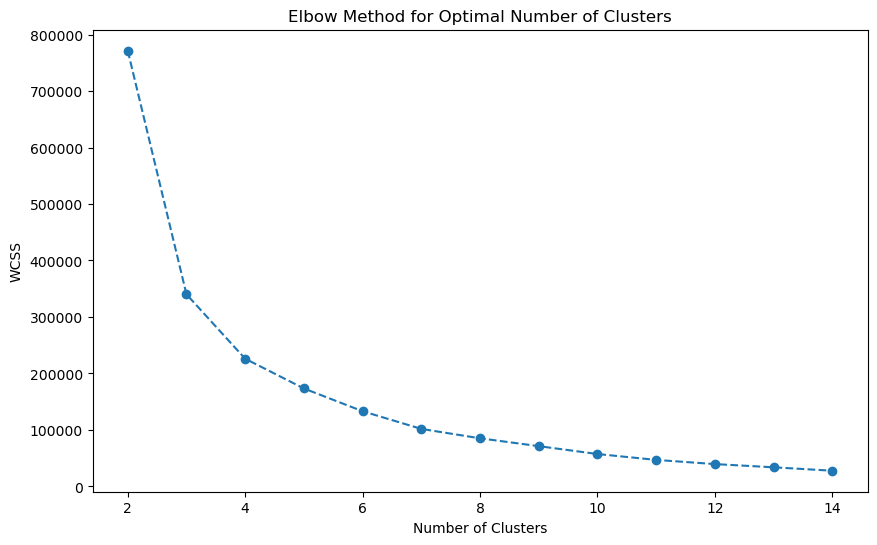

In [3]:
# Start the timer
start_time = time.time()

# Function to run KMeans and return inertia (WCSS) for a given number of clusters
def compute_wcss(n_clusters, scaled_features):
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=30)
    kmeans.fit(scaled_features)
    return kmeans.inertia_

# Define the range of clusters to test
cluster_range = range(2, 15)

# Parallelize the computation of WCSS (inertia) for each number of clusters
wcss = Parallel(n_jobs=1)(delayed(compute_wcss)(i, scaled_features) for i in cluster_range)

# Stop the timer
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000

print(f"Elapsed time for elbow method is : {elapsed_time_ms:.2f} milliseconds")

# Plot the Elbow Graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

In [5]:

# Start the timer
start_time = time.time()

# Define the number of clusters
num_clusters = 4

# Apply K-Means with K-Means++ initialization
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=30)
kmeans.fit(scaled_features)
clusters = kmeans.predict(scaled_features)

# Function to compute silhouette score for a subset of the data
def compute_silhouette_score_chunk(chunk, chunk_clusters):
    return silhouette_score(chunk, chunk_clusters)

# Split the dataset and clusters into chunks
num_chunks = 1000  # Split into 1000 chunks
chunks = np.array_split(scaled_features, num_chunks)
cluster_chunks = np.array_split(clusters, num_chunks)

# Determine the number of available CPU cores
available_cores = cpu_count()

# Set the number of cores to use
n_jobs = 1  # Use all available CPU cores

# Print the number of cores being used
print(f"Number of available cores: {available_cores}")
if n_jobs == -1:
    print(f"Using all {available_cores} cores for parallel processing.")
else:
    if n_jobs == 1:
        print(f"Using {n_jobs} core for parallel processing.")
    else:
        print(f"Using {n_jobs} cores for parallel processing.")

# Parallelize silhouette score calculation across chunks
silhouette_scores = Parallel(n_jobs=n_jobs)(
    delayed(compute_silhouette_score_chunk)(chunk, chunk_clusters)
    for chunk, chunk_clusters in zip(chunks, cluster_chunks)
)

# Average the silhouette scores across chunks
# Average distance to all other data points within the same cluster (cohesion).
# Average distance to all data points in the nearest neighboring cluster (separation).
# silhouette coefficient = (separation — cohesion) / max(separation, cohesion)
silhouette_avg = np.mean(silhouette_scores)
print("For n_clusters =", num_clusters, "The average silhouette_score is :", silhouette_avg)

# Stop the timer
end_time = time.time()
elapsed_time_ms = (end_time - start_time) * 1000
print(f"Elapsed time for K-means clustering: {elapsed_time_ms:.2f} milliseconds")

# Get the cluster labels
labels = kmeans.labels_

# Add the cluster labels to the original dataset
data['Cluster'] = labels





Number of available cores: 10
Using 1 core for parallel processing.
For n_clusters = 4 The average silhouette_score is : 0.5718825090150854
Elapsed time for K-means clustering: 14494.86 milliseconds


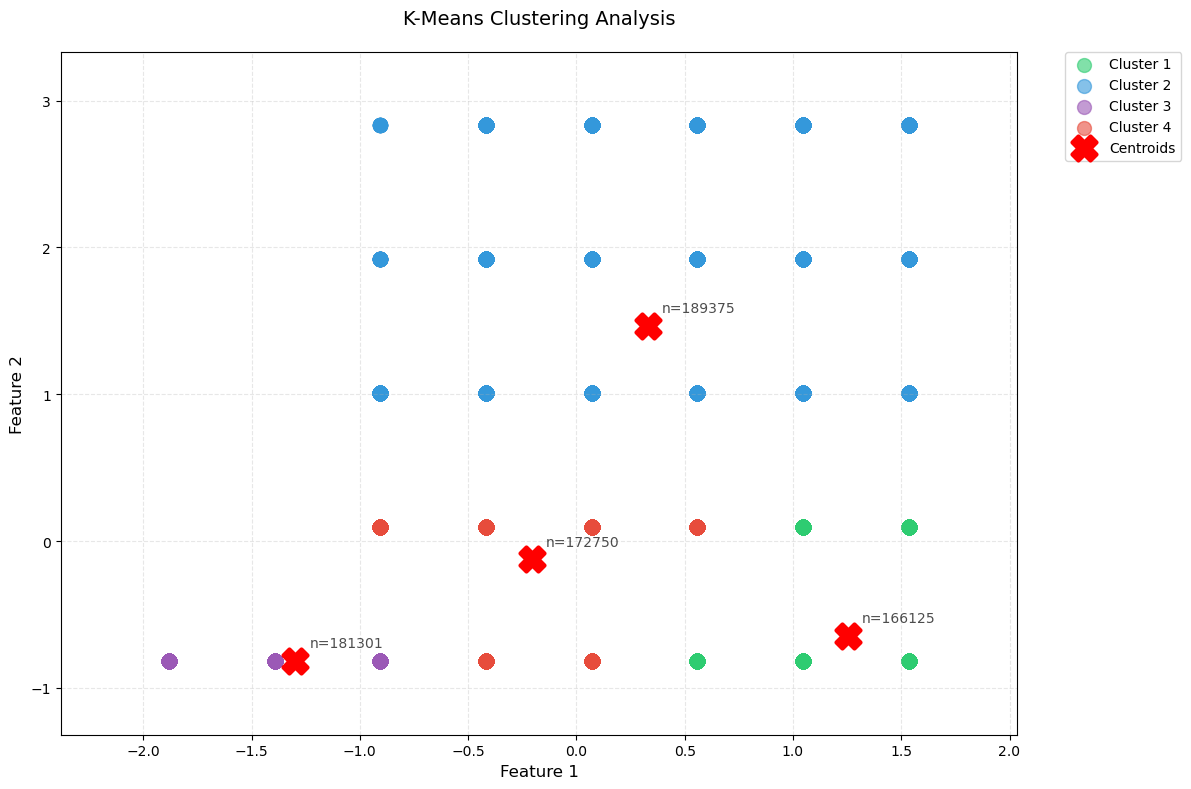

In [27]:
def plot_kmeans_clusters(scaled_features, clusters, kmeans, figsize=(12, 8)):
    # Create custom colormap for better distinction between clusters
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f1c40f']
    
    # Create the figure and axis
    plt.figure(figsize=figsize)
    
    # Plot the data points
    for i in range(len(np.unique(clusters))):
        cluster_points = scaled_features[clusters == i]
        plt.scatter(cluster_points[:, 0], 
                   cluster_points[:, 1],
                   c=[colors[i]], 
                   s=100,
                   alpha=0.6,
                   label=f'Cluster {i+1}')
    
    # Plot centroids with larger X markers
    plt.scatter(kmeans.cluster_centers_[:, 0],
               kmeans.cluster_centers_[:, 1],
               c='red',
               marker='X',
               s=300,
               linewidths=3,
               label='Centroids',
               zorder=10)
    
    # Add gridlines
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Set axis limits with some padding
    x_min, x_max = scaled_features[:, 0].min() - 0.5, scaled_features[:, 0].max() + 0.5
    y_min, y_max = scaled_features[:, 1].min() - 0.5, scaled_features[:, 1].max() + 0.5
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Customize the plot
    plt.title('K-Means Clustering Analysis', fontsize=14, pad=20)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    
    # Add legend with better positioning
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Optional: Add cluster sizes annotation
    for i, center in enumerate(kmeans.cluster_centers_):
        cluster_size = np.sum(clusters == i)
        plt.annotate(f'n={cluster_size}',
                    (center[0], center[1]),
                    xytext=(10, 10),
                    textcoords='offset points',
                    fontsize=10,
                    alpha=0.7)
    
    plt.show()

# Usage:
plot_kmeans_clusters(scaled_features, clusters, kmeans)